## Install surprise (A python scikit for recommender systems)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/recommender_system

/content/drive/MyDrive/recommender_system


In [ ]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 33.8 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633962 sha256=80f6c1d49c92d5d0d0b4cfa846742f361c9a969cebe6ad8303a4ba5e574966ac
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


## Load packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import random

from IPython.display import display
from tqdm import tqdm
from collections import defaultdict

seed = 0
np.random.seed(seed)
random.seed(seed)
warnings.filterwarnings(action='ignore')

## Load dataset

#### Netflix held the Netflix Prize open competition for the best algorithm to predict user ratings for films.   
#### This is the dataset that was used in that competition. It consists of user id and ratings (1~5) that a user rated to a movie.

In [ ]:
# Skip date
df = pd.read_csv('combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df['Rating'] = df['Rating'].astype(float)

print('shape: {}\n'.format(df.shape))
print('-Dataset examples-')
df.iloc[::5000000, :]

shape: (24058263, 2)

-Dataset examples-


,Cust_Id,Rating
0,1:,NaN
5000000,2560324,4.0
10000000,2271935,2.0
15000000,1921803,2.0
20000000,1933327,3.0


## The shape of the dataset

#### - The dataset has two columns, Cust_Id and Rating. 
#### - Each row indicates the rating that a user (Cust_Id) gave to a movie.  
#### - The row with the rating 'NaN' indicates the Movie_Id (Item_Id). 


In [ ]:
display(df.loc[0:2, :])
display(df.loc[548:551, :])
display(df.loc[694:696, :])

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0


,Cust_Id,Rating
548,2:,NaN
549,2059652,4.0
550,1666394,3.0
551,1759415,4.0


,Cust_Id,Rating
694,3:,NaN
695,1025579,4.0
696,712664,5.0


## Add movie ID column

In [ ]:
ratings = df.Rating.values
movie_id_arr = np.cumsum(np.isnan(ratings))
df['Movie_Id'] = movie_id_arr
df = df.dropna(axis=0)
df.Cust_Id = df.Cust_Id.astype(int)

print(f'총 rating 수 : {len(df)}')
display(df.loc[::5000,:])

총 rating 수 : 24053764


,Cust_Id,Rating,Movie_Id
1,1488844,3.0,1
5006,1189445,1.0,6
10008,2421394,3.0,8
15008,2342811,3.0,8
20008,1834737,3.0,8
...,...,...,...
24034492,819546,2.0,4492
24039492,2570403,1.0,4492
24044493,1042113,4.0,4493
24049496,1059719,3.0,4496


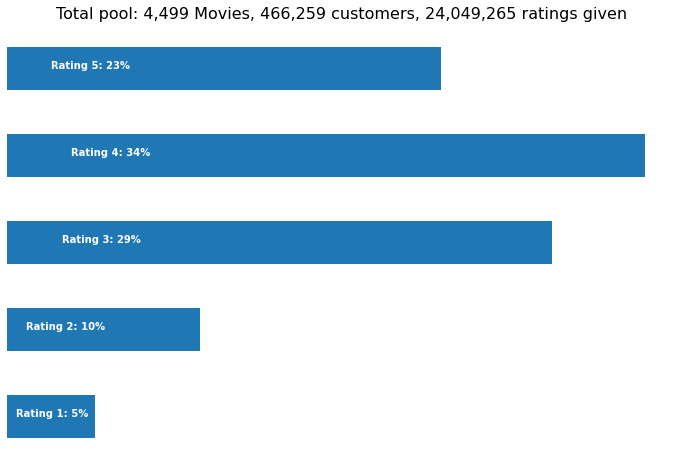

In [ ]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.Movie_Id.nunique()

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (12,8))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=16)
plt.axis('off')

for i in range(1, 6):
    ax.text(p.iloc[i-1][0]/10, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

## Movie ID-Title dataset

In [ ]:
df_title = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
df_title.head(10)

,Year,Name
Movie_Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW
6,1997.0,Sick
7,1992.0,8 Man
8,2004.0,What the #$*! Do We Know!?
9,1991.0,Class of Nuke 'Em High 2


## Build the dataset (user-item matrix)

#### For the fast implementation, I randomly select 500 users and their all interactions.

In [ ]:
from surprise import Reader, Dataset

In [ ]:
reader = Reader()

# just get interactions of 500 users randomly
n_users = 500
all_users = df.Cust_Id.unique()
sampled_users = np.random.choice(all_users, n_users, replace=False)
df_sample = df.loc[df['Cust_Id'].isin(sampled_users)]
print('{} interactions, {} users, {} movies are selected.'.format(len(df_sample), df_sample.Cust_Id.nunique(), df_sample.Movie_Id.nunique()))
print('only {:.2f}% of possible interactions are observed'.format(len(df_sample) / (df_sample.Cust_Id.nunique()*df_sample.Movie_Id.nunique()) *100))

data = Dataset.load_from_df(df_sample[['Cust_Id', 'Movie_Id', 'Rating']], reader)
unobserved_data = data.build_full_trainset().build_anti_testset()


26124 interactions, 500 users, 2191 movies are selected.
only 2.38% of possible interactions are observed


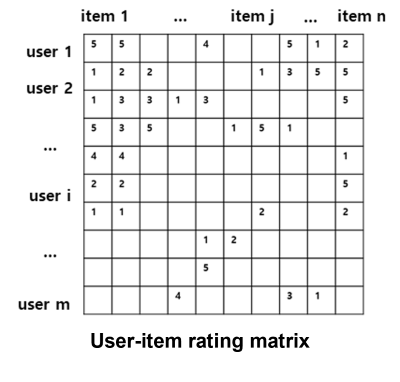

In [ ]:
# 리뷰어 ID, 영화 ID, 평점, 시간
data.raw_ratings[:10]

[(691460, 5, 3.0, None),
 (107840, 8, 2.0, None),
 (732873, 8, 3.0, None),
 (2621026, 8, 4.0, None),
 (497548, 8, 4.0, None),
 (230186, 8, 3.0, None),
 (46716, 8, 4.0, None),
 (2453978, 8, 2.0, None),
 (2383529, 8, 3.0, None),
 (2537651, 8, 2.0, None)]

### Train the model

* In this part, we train two matrix factorization models for recommendation, **SVD**(Singular Value Decomposition) and **NMF**(Nonnegative Matrix Factorization)

In [ ]:
from surprise import SVD, NMF, accuracy
from surprise.model_selection import cross_validate

# hyperparameters for training the model
# n_factors = 30
# n_epochs = 100
# biased = True
# lr_all = 0.005
# reg_all = 0.02

In [ ]:
# initialize SVD 



In [ ]:
# cross validation of SVD



Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0409  1.0461  1.0382  1.0412  1.0218  1.0377  0.0083  
MAE (testset)     0.8122  0.8117  0.8084  0.8068  0.8007  0.8079  0.0042  
Fit time          5.93    3.06    3.02    3.08    3.01    3.62    1.15    
Test time         0.03    0.12    0.03    0.03    0.03    0.05    0.03    


In [ ]:
# initialize NMF



In [ ]:
# cross validation of NMF



Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.6593  1.5286  1.5485  1.7080  1.5725  1.6034  0.0687  
MAE (testset)     1.2756  1.1650  1.1919  1.3456  1.2164  1.2389  0.0647  
Fit time          4.10    4.02    4.77    4.71    4.17    4.35    0.32    
Test time         0.04    0.06    0.17    0.04    0.09    0.08    0.05    


In [ ]:
# find the best hyperparapmeter of your model by gridsearchCV

from surprise.model_selection import GridSearchCV

param_grid = {
    'n_factors': , 
    'n_epochs': ,
    }
gs = GridSearchCV(SVD, param_grid, measures=['RMSE', 'MAE'], cv = 3)
gs.fit(data)

In [ ]:
print('Best RMSE: {:.5f} | params for the best RMSE: {}'.format(gs.best_score['rmse'], gs.best_params['rmse']))
print('Best MAE: {:.5f} | params for the best MAE: {}'.format(gs.best_score['mae'], gs.best_params['mae']))

Best RMSE: 0.98577 | params for the best RMSE: {'n_factors': 30, 'n_epochs': 50}
Best MAE: 0.76999 | params for the best MAE: {'n_factors': 30, 'n_epochs': 50}


### See how matrix factorization estimates unknown ratings

In [ ]:
n_factors, n_epochs = gs.best_params['rmse']['n_factors'], gs.best_params['rmse']['n_epochs']

# initialize the model
algo = SVD(n_factors=n_factors, n_epochs=n_epochs, biased=biased, random_state=seed,)
# trainset is the total observed ratings
trainset = data.build_full_trainset()
# train the model with the trainset
algo.fit(trainset)
# predict the values of unobserved ratings
unobserved_pred = algo.test(unobserved_data)

In [ ]:
user_dict = {i:trainset.to_raw_uid(i) for i in trainset.all_users()} # raw user id: encoded user id
item_dict = {i:trainset.to_raw_iid(i) for i in trainset.all_items()} # raw item id: encoded item id

In [ ]:
print('(encoded id, raw id):', list(user_dict.items())[:5])
print('(encoded id, raw id)    :', list(item_dict.items())[:5])

(encoded id, raw id): [(0, 691460), (1, 107840), (2, 732873), (3, 2621026), (4, 497548)]
(encoded id, raw id)    : [(0, 5), (1, 8), (2, 15), (3, 16), (4, 17)]


In [ ]:
uid = 0
iid = 0

pu = algo.pu[uid]
qi = algo.qi[iid]
bu = algo.bu[uid]
bi = algo.bi[iid]

print('Shape of user latent vector (p_u) = (n_user, n_latent)={}: \nEx) User factor of user {} (raw id: {})\n{}\n'.format(algo.pu.shape, uid, user_dict[uid], pu))
print('Shape of item latent vector (q_i) = (n_item, n_latent)={}: \nEx) Item factor of movie {} (raw id: {})\n{}\n'.format(algo.qi.shape, iid, item_dict[iid], qi))
print('Shape of user bias (b_u) = (n_user, )={}: \nEx) User bias of user {} (실제 id: {}): {}\n'.format(algo.bu.shape, uid, user_dict[uid], bu))
print('Shape of item bias (b_i) = (n_item, )={}: \nEx) Item bias of movie {} (실제 id: {}): {}'.format(algo.bi.shape, iid, item_dict[iid], bi))

Shape of user latent vector (p_u) = (n_user, n_latent)=(500, 30): 
Ex) User factor of user 0 (raw id: 691460)
[ 0.35315921 -0.01073576  0.03505258  0.24486072  0.13059466 -0.22968444
 -0.00175917 -0.18739104  0.05679627 -0.04210498  0.09576017  0.2435732
  0.05600179  0.28365225  0.02079692  0.07620831  0.13621075 -0.08856649
  0.04722949 -0.08506418 -0.27652387  0.00284802  0.01326324  0.07552191
  0.26433375 -0.17148424  0.07012181 -0.05342214  0.43086364  0.35634425]

Shape of item latent vector (q_i) = (n_item, n_latent)=(2191, 30): 
Ex) Item factor of movie 0 (raw id: 5)
[ 1.87703171e-01  5.42084675e-02 -5.47302275e-02 -8.56857829e-03
  1.37929807e-02  1.59904845e-01 -1.15301616e-01 -2.29806731e-02
  4.27807231e-03 -6.49872454e-02  8.33221498e-02 -1.15368149e-01
 -1.05613862e-01 -1.00468515e-01  1.75965897e-01  9.29405536e-02
  2.54643526e-02  4.57304022e-02 -1.64892692e-01 -2.84369756e-01
 -8.82302082e-02 -6.63163016e-02 -1.68326744e-01 -2.62927015e-02
 -5.97319793e-02 -1.6354465

In [ ]:
# prediction by SVD.predict method
algo.predict(user_dict[uid], item_dict[iid])

Prediction(uid=691460, iid=5, r_ui=None, est=3.879895277038679, details={'was_impossible': False})

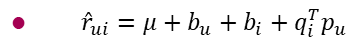

In [ ]:
# manual calculation
trainset.global_mean + bu + bi + np.dot(pu, qi)

3.879895277038679

## Top-N recommendation

#### Recommend N items that a user is expected to like (items with N highest predicted ratings) to the user who has ever rated.

In [ ]:
def get_top_n(predictions, user_dict, user, n=10):
    """
    Return the top-N recommendation for each user from a set of predictions.
    [(raw item id, rating estimation), ...] of size n.
    """
    







    
    return top_n

In [ ]:
top_n = get_top_n(unobserved_pred, user_dict, user=0, n=10)

Top-10 recommendations for user 0 (raw id: 691460)
r_est: 5.00000 | movie ID:  171 | name: Funny Face
r_est: 5.00000 | movie ID:  241 | name: North by Northwest
r_est: 5.00000 | movie ID:  270 | name: Sex and the City: Season 4
r_est: 5.00000 | movie ID:  395 | name: Captain Blood
r_est: 5.00000 | movie ID:  422 | name: The Unsinkable Molly Brown
r_est: 5.00000 | movie ID:  443 | name: Rabbit-Proof Fence
r_est: 5.00000 | movie ID:  463 | name: The Twilight Zone: Vol. 12
r_est: 5.00000 | movie ID:  646 | name: Matewan
r_est: 5.00000 | movie ID:  752 | name: Star Trek: The Next Generation: Season 7
r_est: 5.00000 | movie ID:  872 | name: Seven Samurai


In [ ]:
top_n = get_top_n(unobserved_pred, user_dict, user=40, n=10)

Top-10 recommendations for user 40 (raw id: 1038731)
r_est: 5.00000 | movie ID:   57 | name: Richard III
r_est: 5.00000 | movie ID:  270 | name: Sex and the City: Season 4
r_est: 5.00000 | movie ID:  395 | name: Captain Blood
r_est: 5.00000 | movie ID:  422 | name: The Unsinkable Molly Brown
r_est: 5.00000 | movie ID:  443 | name: Rabbit-Proof Fence
r_est: 5.00000 | movie ID:  494 | name: Monty Python's The Meaning of Life: Special Edition
r_est: 5.00000 | movie ID:  646 | name: Matewan
r_est: 5.00000 | movie ID:  752 | name: Star Trek: The Next Generation: Season 7
r_est: 5.00000 | movie ID:  872 | name: Seven Samurai
r_est: 5.00000 | movie ID:  886 | name: Ray


## List of movies with similar preference

#### Gives a list of N movies of similar preference of users given a guery movie.

In [ ]:
def similar_movies(algo, item_dict, item, n):
    
    # latent vector of the item 
    # latent vector of all items
    
    # cosine similarities b/w the query item and all items
    
    # the n most similar movies by cosine similarities of latent vectors
    # 입력한 영화와 사용자 선호에 대한 유사도가 가장 높은 n개 영화 id 







    return df_title.loc[most_similar_movies]

In [ ]:
similar_movies(algo, item_dict, item=10, n=10)

Query movie : Never Die Alone



,Year,Name
Movie_Id,,
705,1989.0,Major League
3437,1994.0,The Stand
2176,2000.0,VeggieTales: Esther
4366,2000.0,Soul Food: Season 1
1636,1989.0,The Lady and the Highwayman
4041,2004.0,Mobile Suit Gundam SEED
947,1965.0,The Cincinnati Kid
3263,2004.0,Broadway: The Golden Age
1163,1984.0,2010: The Year We Make Contact


### Visualizing the movie Factors Using t-SNE


In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=10, n_iter=1000, verbose=3, random_state=seed)
movie_embedding = tsne.fit_transform(algo.qi)

In [ ]:
projection = pd.DataFrame(columns=['x', 'y'], data=movie_embedding)
movie_names = [df_title.loc[val, 'Name'] for key, val in item_dict.items()]
encoded_movie_ids = list(item_dict.keys())
projection['Title'] = movie_names
projection['Movie_Id_Encoded'] = encoded_movie_ids
projection

In [ ]:
n_samples = 100
projection_plot = projection.loc[:n_samples]
fig, ax = plt.subplots(figsize=(24, 12))
ax.scatter(projection_plot.x.values, projection_plot.y.values, alpha=0.5)
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)
ax.set_title('Visualization of the movie factors', size=16)
for i, (mid, txt) in enumerate(zip(projection_plot.Movie_Id_Encoded, projection_plot.Title)):
    ax.annotate('{}: {}'.format(mid, txt), (projection_plot.x.values[i], projection_plot.y.values[i]), fontsize=11.5)